SEÑAL CRUDA


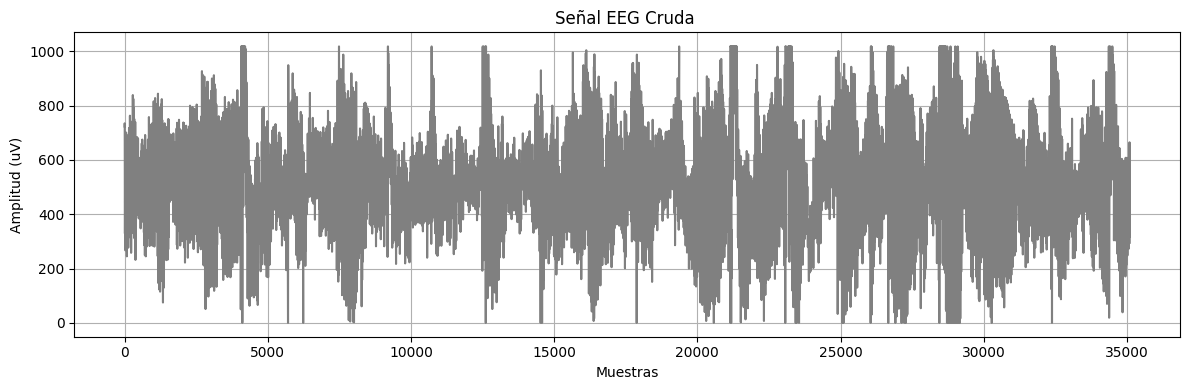

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Cargar la señal EEG desde el archivo
data = np.loadtxt('masticar.txt')

# La señal cruda está en la última columna
raw_signal = data[:, -1]
fs = 1000  # Frecuencia de muestreo en Hz, asumida por formato de BITalino

# Visualización de la señal cruda
plt.figure(figsize=(12, 4))
plt.plot(raw_signal, color='gray')
plt.title("Señal EEG Cruda ")
plt.xlabel("Muestras")
plt.ylabel("Amplitud (uV)")
plt.grid(True)
plt.tight_layout()
plt.savefig("senal_cruda_libre.jpg", dpi=300)
plt.show()


SEÑAL FILTRADA


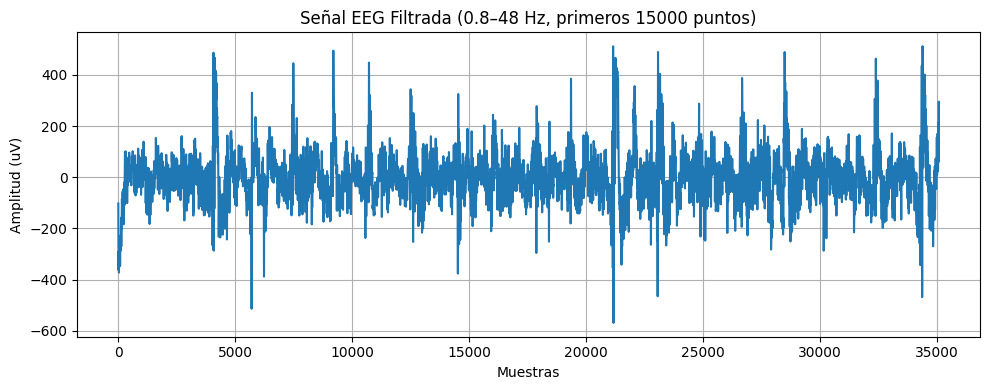

In [ ]:
# Función para filtro pasa banda
def bandpass_filter(signal, lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs  # Frecuencia de Nyquist
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

# Aplicar filtro pasa banda entre 0.8 Hz y 48 Hz
fs = 1000  # Frecuencia de muestreo según el encabezado
filtered_signal = bandpass_filter(raw_signal, 0.8, 48, fs)

# Graficar señal filtrada
plt.figure(figsize=(10, 4))
plt.plot(filtered_signal)
plt.title("Señal EEG Filtrada (0.8–48 Hz, primeros 15000 puntos)")
plt.xlabel("Muestras")
plt.ylabel("Amplitud (uV)")
plt.grid(True)
plt.tight_layout()
plt.savefig("senal_filtrada_libre.jpg", dpi=300)
plt.show()


Número de artefactos de parpadeo detectados: 156


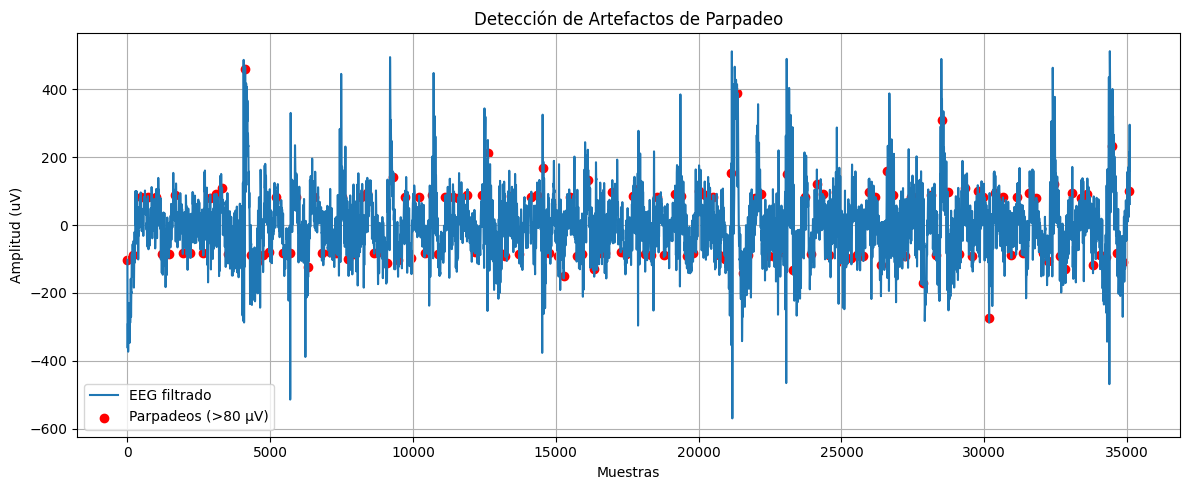

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Umbral para detectar parpadeos (μV)
umbral = 80


# Detectar cruces de umbral
artefactos = np.where(np.abs(filtered_signal) > umbral)[0]

# Agrupar eventos cercanos (ej: si duran varios ms no contar más de una vez)
min_separacion = 200  # en muestras, ~200 ms si fs=1000Hz
artefactos_filtrados = []

ultimo = -min_separacion
for idx in artefactos:
    if idx - ultimo >= min_separacion:
        artefactos_filtrados.append(idx)
        ultimo = idx

# Mostrar resultados
print(f"Número de artefactos de parpadeo detectados: {len(artefactos_filtrados)}")

# Graficar con marcas
plt.figure(figsize=(12, 5))
plt.plot(filtered_signal, label="EEG filtrado")
plt.scatter(artefactos_filtrados, filtered_signal[artefactos_filtrados], color='red', label="Parpadeos (>80 μV)")
plt.title("Detección de Artefactos de Parpadeo")
plt.xlabel("Muestras")
plt.ylabel("Amplitud (uV)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("artefactos_detectados.jpg", dpi=300)
plt.show()


SEÑAL FILTRADA


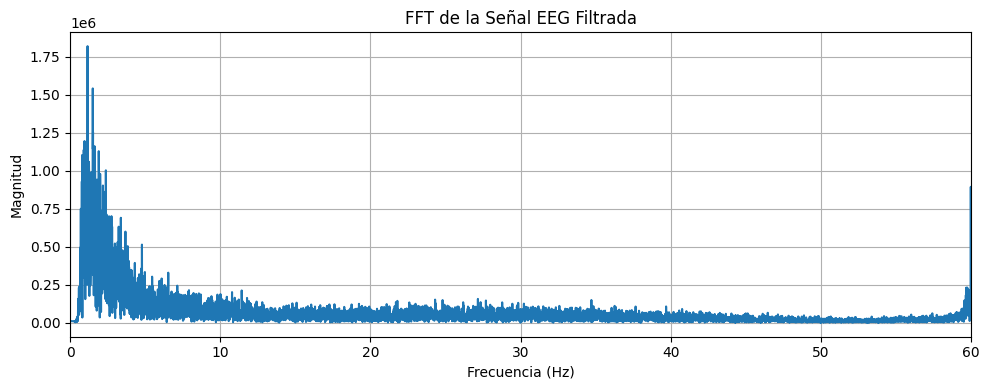

In [ ]:
# Calcular FFT
from numpy.fft import fft, fftfreq
n = len(filtered_signal)
fft_vals = fft(filtered_signal)
fft_freqs = fftfreq(n, 1/fs)

# Tomar solo la parte positiva del espectro
positive_freqs = fft_freqs[:n // 2]
positive_fft_vals = np.abs(fft_vals[:n // 2])

# Graficar la FFT
plt.figure(figsize=(10, 4))
plt.plot(positive_freqs, positive_fft_vals)
plt.title("FFT de la Señal EEG Filtrada")
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Magnitud")
plt.grid(True)
plt.xlim(0, 60)
plt.tight_layout()
plt.savefig("senal_libre_fft.jpg", dpi=300)
plt.show()


PDS


(0.0, 50.0)

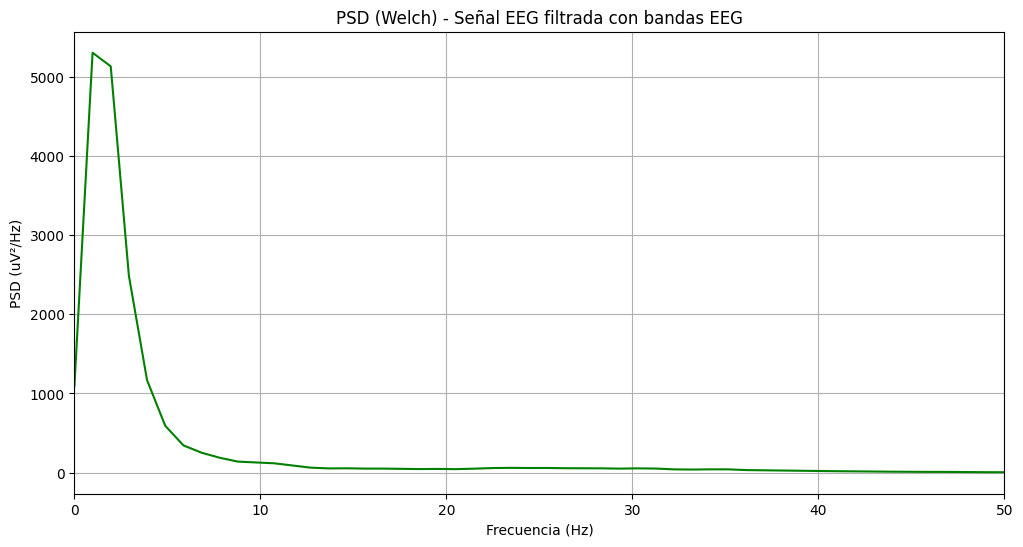

In [ ]:
# Calcular PSD con la señal limpia
frequencies, psd = welch(filtered_signal, fs, nperseg=1024)

# Gráfico
plt.figure(figsize=(12, 6))
plt.plot(frequencies, psd, color="green")
plt.title("PSD (Welch) - Señal EEG filtrada con bandas EEG")
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("PSD (uV²/Hz)")
plt.grid(True)
plt.xlim(0, 50)

<ipython-input-54-8fb09c786d5e>:14: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total_power = np.trapz(psd, frequencies)
<ipython-input-54-8fb09c786d5e>:20: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  band_power = np.trapz(psd[idx], frequencies[idx])


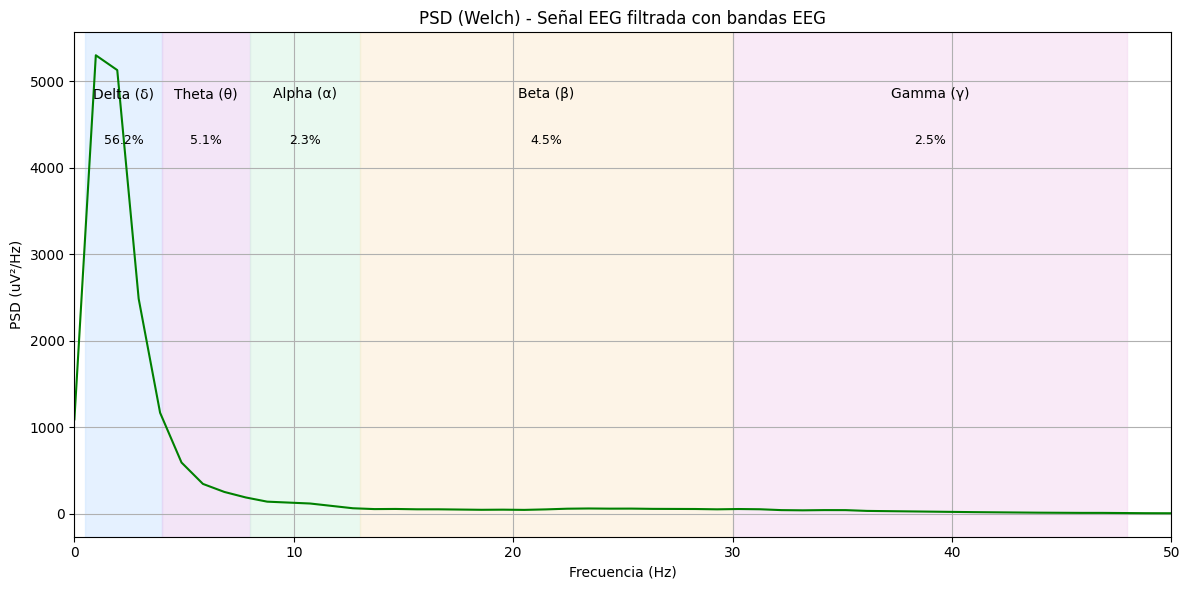

In [ ]:
# Calcular PSD con la señal limpia
frequencies, psd = welch(filtered_signal, fs, nperseg=1024)

# Rango de bandas EEG extendido
bands = {
    'Delta (δ)': (0.5, 4),
    'Theta (θ)': (4, 8),
    'Alpha (α)': (8, 13),
    'Beta (β)': (13, 30),
    'Gamma (γ)': (30, 48)
}

# Calcular la potencia total en cada banda y el porcentaje relativo
total_power = np.trapz(psd, frequencies)
band_powers = {}
relative_powers = {}

for band, (low, high) in bands.items():
    idx = np.logical_and(frequencies >= low, frequencies <= high)
    band_power = np.trapz(psd[idx], frequencies[idx])
    band_powers[band] = band_power
    relative_powers[band] = (band_power / total_power) * 100 if total_power > 0 else 0

# Gráfico
plt.figure(figsize=(12, 6))
plt.plot(frequencies, psd, color="green")
plt.title("PSD (Welch) - Señal EEG filtrada con bandas EEG")
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("PSD (uV²/Hz)")
plt.grid(True)
plt.xlim(0, 50)

# Colorear las bandas y mostrar porcentaje
colors = {
    'Delta (δ)': '#cce5ff',
    'Theta (θ)': '#e8ccf0',
    'Alpha (α)': '#d5f5e3',
    'Beta (β)': '#fdebd0',
    'Gamma (γ)': '#f4d6f0'
}

for band, (low, high) in bands.items():
    plt.axvspan(low, high, color=colors[band], alpha=0.5)
    mid = (low + high) / 2
    power_percent = f"{relative_powers[band]:.1f}%"
    plt.text(mid, max(psd) * 0.9, band, ha='center', va='bottom', fontsize=10)
    plt.text(mid, max(psd) * 0.8, power_percent, ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig("senal_libre_PSD.jpg", dpi=300)
plt.show()


ANÁLISIS CUANTITATIVO

<ipython-input-55-b52e0e3bf9d9>:21: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total_power = np.trapz(psd, freqs)
<ipython-input-55-b52e0e3bf9d9>:23: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  band_power = np.trapz(psd[idx], freqs[idx])


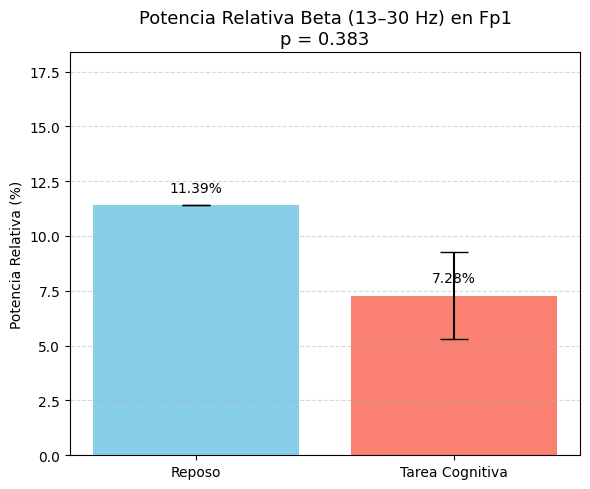

In [ ]:
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt, welch
from scipy.stats import ttest_rel
import matplotlib.pyplot as plt

# Definición de parámetros
fs = 1000  # Frecuencia de muestreo
beta_band = (13, 30)

# Funciones auxiliares
def load_and_filter(filepath, column_index, fs, band=(0.8, 48)):
    df = pd.read_csv(filepath, sep="\t", comment='#', header=None)
    signal = df.iloc[:, column_index].dropna().values
    b, a = butter(4, [band[0]/(fs/2), band[1]/(fs/2)], btype='band')
    filtered = filtfilt(b, a, signal)
    return filtered

def get_relative_band_power(signal, fs, band):
    freqs, psd = welch(signal, fs, nperseg=1024)
    total_power = np.trapz(psd, freqs)
    idx = np.logical_and(freqs >= band[0], freqs <= band[1])
    band_power = np.trapz(psd[idx], freqs[idx])
    return (band_power / total_power) * 100 if total_power > 0 else 0

# Cargar señales (Fp1 = columna 1)
reposo1 = load_and_filter("basal1.txt", column_index=5, fs=fs)
reposo2 = load_and_filter("basal1.txt", column_index=5, fs=fs)
tarea1 = load_and_filter("preguntas1.txt", column_index=5, fs=fs)
tarea2 = load_and_filter("preguntas_dificiles.txt", column_index=5, fs=fs)

# Calcular potencias relativas en banda Beta
beta_reposo = [get_relative_band_power(reposo1, fs, beta_band),
               get_relative_band_power(reposo2, fs, beta_band)]

beta_tarea = [get_relative_band_power(tarea1, fs, beta_band),
              get_relative_band_power(tarea2, fs, beta_band)]

# Prueba t pareada
t_stat, p_val = ttest_rel(beta_reposo, beta_tarea)

# Gráfico
labels = ['Reposo', 'Tarea Cognitiva']
means = [np.mean(beta_reposo), np.mean(beta_tarea)]
sems = [np.std(beta_reposo)/np.sqrt(len(beta_reposo)),
        np.std(beta_tarea)/np.sqrt(len(beta_tarea))]

plt.figure(figsize=(6, 5))
bars = plt.bar(labels, means, yerr=sems, capsize=10, color=['skyblue', 'salmon'])
for bar, mean in zip(bars, means):
    plt.text(bar.get_x() + bar.get_width()/2.0, mean + 0.5, f'{mean:.2f}%',
             ha='center', va='bottom', fontsize=10)

plt.title(f"Potencia Relativa Beta (13–30 Hz) en Fp1\np = {p_val:.3f}", fontsize=13)
plt.ylabel("Potencia Relativa (%)")
plt.ylim(0, max(means) + max(sems) + 5)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("incremento_theta.jpg", dpi=300)
plt.show()

